In [14]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Link CSV từ Google Sheets
url = "https://docs.google.com/spreadsheets/d/1JCmLloO4IGhTaf8t6nEa-MZO8BYwtrnY/export?format=csv&gid=1998513663"
df = pd.read_csv(url, decimal=',')
print("Dữ liệu ban đầu:")
print(df.head())

Dữ liệu ban đầu:
         Date  Gold Price  Oil Price  Gold Pct Change  Oil Pct Change  \
0  03/01/2020  1549.19995      63.05          0.01620         0.03057   
1  06/01/2020  1566.19995      63.27          0.01097         0.00349   
2  07/01/2020  1571.80005      62.70          0.00358        -0.00901   
3  08/01/2020  1557.40002      59.61         -0.00916        -0.04928   
4  09/01/2020  1551.69995      59.56         -0.00366        -0.00084   

   Gold Log Return  Oil Log Return  Gold_RollingStd  Oil_RollingStd  \
0          0.01607         0.03011              NaN             NaN   
1          0.01091         0.00348              NaN             NaN   
2          0.00357        -0.00905              NaN             NaN   
3         -0.00920        -0.05054              NaN             NaN   
4         -0.00367        -0.00084              NaN             NaN   

   Volatility_Ratio  Rolling_Corr     Period  Period_Code  
0               NaN           NaN  Pre-COVID            1

In [3]:
from statsmodels.tsa.stattools import grangercausalitytests

In [4]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF test for {name}:')
    print(f'  Statistic: {result[0]:.4f}')
    print(f'  p-value: {result[1]:.4f}')
    if result[1] < 0.05:
        print("  ✅ Chuỗi dừng (Reject H0)\n")
    else:
        print("  ❌ Chuỗi không dừng (Fail to reject H0)\n")

# Kiểm định ADF cho 2 chuỗi log return
adf_test(df['Gold Log Return'], 'Gold Log Return')
adf_test(df['Oil Log Return'], 'Oil Log Return')

ADF test for Gold Log Return:
  Statistic: -17.0782
  p-value: 0.0000
  ✅ Chuỗi dừng (Reject H0)

ADF test for Oil Log Return:
  Statistic: -6.5490
  p-value: 0.0000
  ✅ Chuỗi dừng (Reject H0)



In [5]:
def granger_test(df, x, y, max_lag=15):
    """Kiểm định Granger: x → y"""
    data = df[[y, x]].dropna()
    results = grangercausalitytests(data, maxlag=max_lag, verbose=False)

    summary = []
    for lag, res in results.items():
        p_val = res[0]['ssr_ftest'][1]
        conclusion = "Có quan hệ Granger" if p_val < 0.05 else "Không có quan hệ"
        summary.append([f"{x} → {y}", lag, round(p_val, 4), conclusion])
    return summary
# Thực hiện kiểm định 2 chiều
results = []
results += granger_test(df, 'Oil Log Return', 'Gold Log Return', max_lag=15)
results += granger_test(df, 'Gold Log Return', 'Oil Log Return', max_lag=15)
# Tạo bảng kết quả
summary_df = pd.DataFrame(results, columns=["Quan hệ kiểm định", "Lag", "P-value", "Kết luận"])
# Chỉ giữ lại các dòng có p-value < 0.05
summary_df = summary_df[summary_df["P-value"] < 0.05]
# Sắp xếp gọn gàng theo độ trễ
summary_df = summary_df.sort_values(by=["Quan hệ kiểm định", "Lag"]).reset_index(drop=True)
# In ra
if summary_df.empty:
    print("❌ Không phát hiện quan hệ Granger có ý nghĩa thống kê (p < 0.05)")
else:
    print(summary_df)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


                  Quan hệ kiểm định  Lag  P-value            Kết luận
0  Oil Log Return → Gold Log Return    8   0.0406  Có quan hệ Granger
1  Oil Log Return → Gold Log Return   11   0.0382  Có quan hệ Granger
2  Oil Log Return → Gold Log Return   12   0.0490  Có quan hệ Granger


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [6]:
from statsmodels.tsa.api import VAR

# Chọn 2 biến log-return
df_var = df[["Gold Log Return", "Oil Log Return"]].dropna()

# Khởi tạo mô hình VAR
model = VAR(df_var)

# Chọn độ trễ tối ưu theo AIC
lag_selection = model.select_order(maxlags=10)
print("Độ trễ tối ưu theo AIC:", lag_selection.aic)

Độ trễ tối ưu theo AIC: 7


In [7]:
# Ước lượng mô hình VAR với lag tối ưu
var_model = model.fit(lag_selection.aic)
# Tạo bảng kết quả gọn: chỉ lấy dầu → vàng và vàng → dầu
results = []
for eq_name in var_model.params.index.get_level_values(0).unique():
    eq = var_model.params.loc[eq_name]
    pvalues = var_model.pvalues.loc[eq_name]

    for param in eq.index:
        # chỉ lấy trường hợp dầu ảnh hưởng vàng hoặc vàng ảnh hưởng dầu
        if ("Gold Log Return" in eq_name and "Oil Log Return" in param) or \
           ("Oil Log Return" in eq_name and "Gold Log Return" in param):

            coef = eq[param]
            pval = pvalues[param]
            if pval < 0.05:  # chỉ giữ hệ số có ý nghĩa thống kê
                results.append([eq_name, param, round(coef, 4), round(pval, 4)])

summary_df = pd.DataFrame(results, columns=["Phương trình", "Biến", "Hệ số", "P-value"])

print("\nCác hệ số dầu ↔ vàng có ý nghĩa thống kê (p < 0.05):")
print(summary_df)


Các hệ số dầu ↔ vàng có ý nghĩa thống kê (p < 0.05):
         Phương trình             Biến   Hệ số  P-value
0  L3.Gold Log Return   Oil Log Return -0.1725   0.0356
1   L6.Oil Log Return  Gold Log Return -0.0246   0.0045


<Figure size 600x400 with 0 Axes>

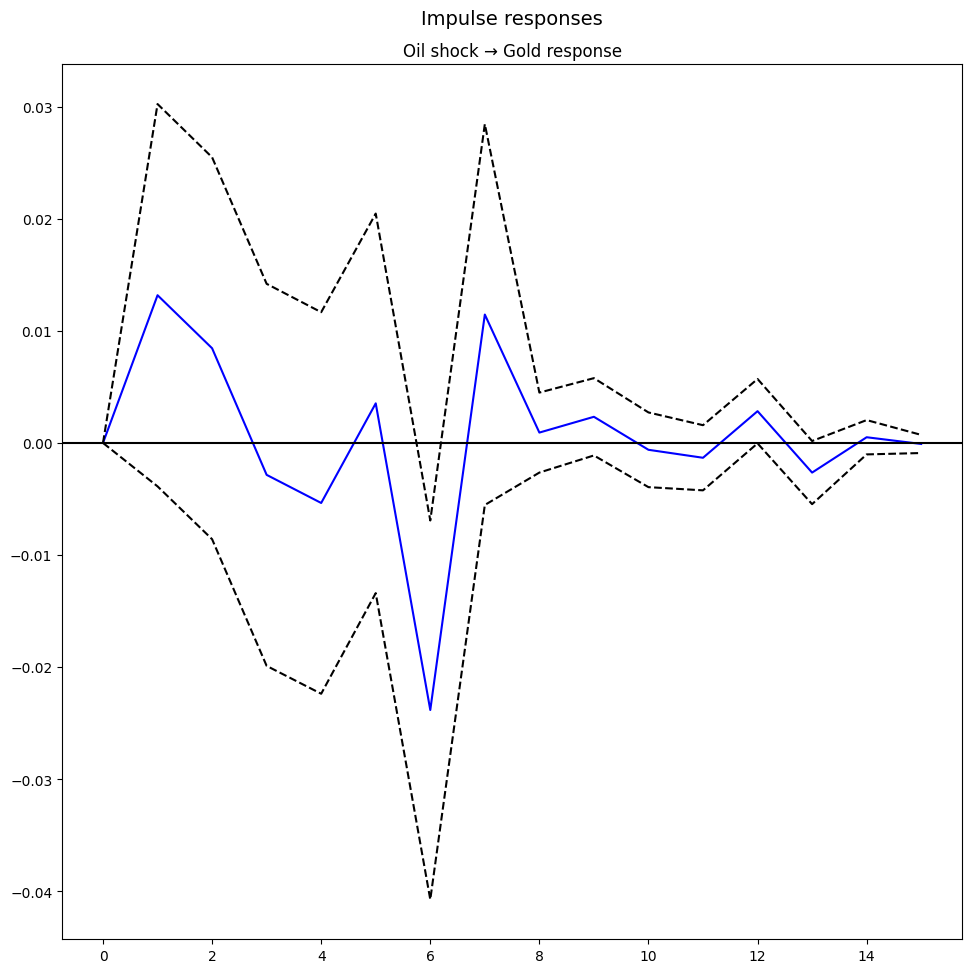

<Figure size 600x400 with 0 Axes>

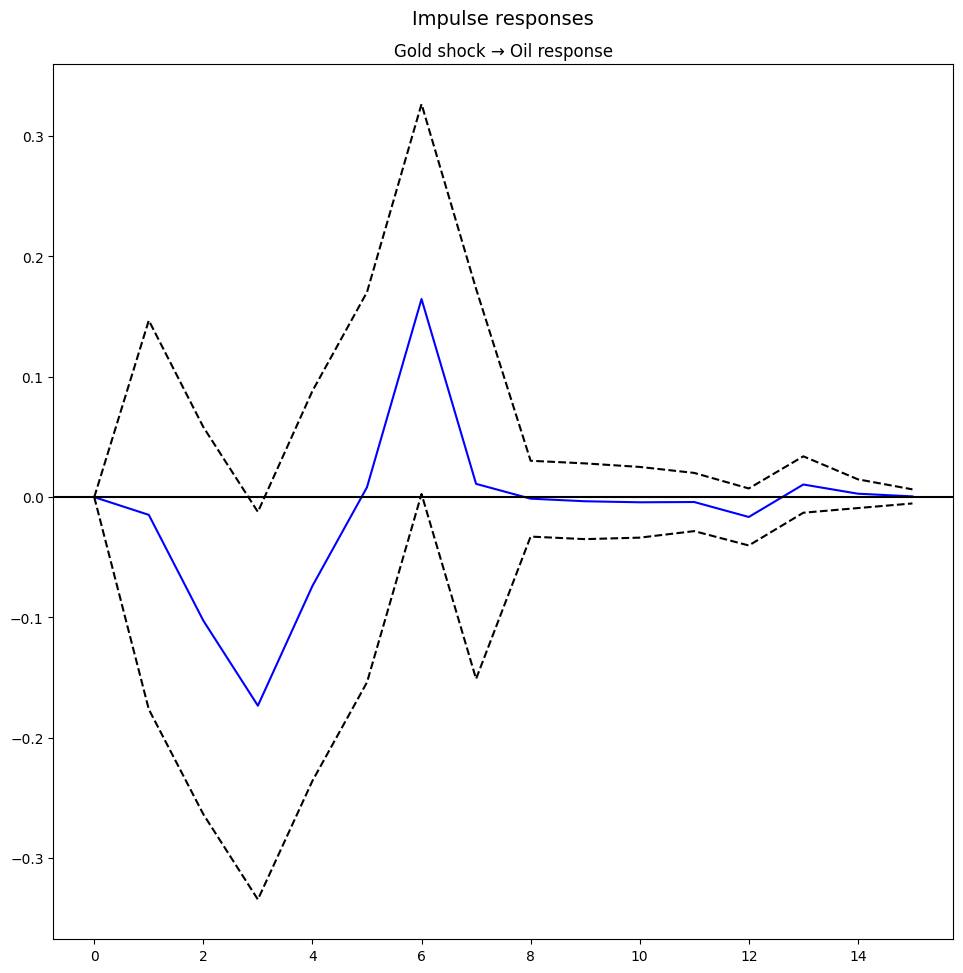

In [8]:
import matplotlib.pyplot as plt

# Tạo đối tượng IRF từ mô hình VAR đã ước lượng
irf = var_model.irf(15)   # phân tích phản ứng trong 15 ngày tiếp theo
# (a) Oil shock → Gold
plt.figure(figsize=(6,4))
irf.plot(impulse='Oil Log Return', response='Gold Log Return', orth=False)
plt.title("Oil shock → Gold response", fontsize=12)
plt.show()

# (b) Gold shock → Oil
plt.figure(figsize=(6,4))
irf.plot(impulse='Gold Log Return', response='Oil Log Return', orth=False)
plt.title("Gold shock → Oil response", fontsize=12)
plt.show()

In [9]:
# --- Chuẩn hóa cột ngày trước khi vẽ ---
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors='coerce')
df = df.dropna(subset=["Date"])

# --- Số ngày cần dự báo ---
forecast_steps = 30

# --- Thực hiện dự báo bằng mô hình đã ước lượng ---
forecast = var_model.forecast(df_var.values[-lag_selection.aic:], steps=forecast_steps)

# --- Chuyển kết quả dự báo thành DataFrame ---
forecast_df = pd.DataFrame(forecast, columns=["Gold Log Return", "Oil Log Return"])

# --- Tính giá dự báo từ log-return ---
last_gold_price = df["Gold Price"].iloc[-1]
last_oil_price = df["Oil Price"].iloc[-1]

forecast_df["Gold Price Forecast"] = last_gold_price * np.exp(forecast_df["Gold Log Return"].cumsum())
forecast_df["Oil Price Forecast"] = last_oil_price * np.exp(forecast_df["Oil Log Return"].cumsum())

# --- Tạo cột thời gian cho 30 ngày tới ---
last_date = pd.to_datetime(df["Date"].iloc[-1])
forecast_dates = pd.date_range(start=last_date, periods=forecast_steps+1, freq='D')[1:]
forecast_df["Date"] = forecast_dates

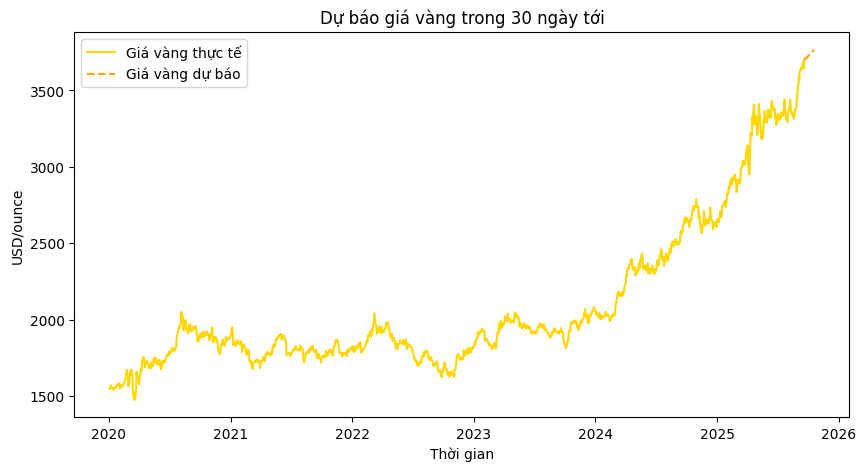

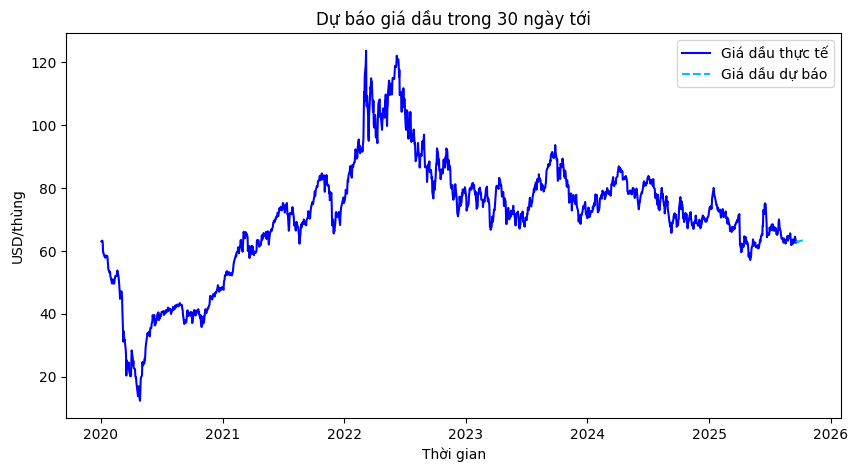

In [10]:
# --- Biểu đồ Dự báo giá vàng ---
plt.figure(figsize=(10,5))
plt.plot(df["Date"], df["Gold Price"], color='gold', label='Giá vàng thực tế')
plt.plot(forecast_df["Date"], forecast_df["Gold Price Forecast"], color='orange', linestyle='--', label='Giá vàng dự báo')
plt.title("Dự báo giá vàng trong 30 ngày tới")
plt.xlabel("Thời gian")
plt.ylabel("USD/ounce")
plt.legend()
plt.show()

# --- Biểu đồ Dự báo giá dầu ---
plt.figure(figsize=(10,5))
plt.plot(df["Date"], df["Oil Price"], color='blue', label='Giá dầu thực tế')
plt.plot(forecast_df["Date"], forecast_df["Oil Price Forecast"], color='deepskyblue', linestyle='--', label='Giá dầu dự báo')
plt.title("Dự báo giá dầu trong 30 ngày tới")
plt.xlabel("Thời gian")
plt.ylabel("USD/thùng")
plt.legend()
plt.show()

In [11]:

from sklearn.metrics import mean_squared_error, mean_absolute_error# --- Đánh giá mô hình ---
# Giả sử bạn chia trước 80% train, 20% test
train_size = int(len(df_var) * 0.8)
train, test = df_var.values[:train_size], df_var.values[train_size:]

model_train = VAR(train)
var_model_fitted = model_train.fit(lag_selection.aic)
forecast_test = var_model_fitted.forecast(train[-lag_selection.aic:], steps=len(test))

# Sai số dự báo
rmse_gold = np.sqrt(mean_squared_error(test[:,0], forecast_test[:,0]))
rmse_oil = np.sqrt(mean_squared_error(test[:,1], forecast_test[:,1]))
mae_gold = mean_absolute_error(test[:,0], forecast_test[:,0])
mae_oil = mean_absolute_error(test[:,1], forecast_test[:,1])

print(f"RMSE (Gold): {rmse_gold:.5f}")
print(f"RMSE (Oil): {rmse_oil:.5f}")
print(f"MAE (Gold): {mae_gold:.5f}")
print(f"MAE (Oil): {mae_oil:.5f}")

RMSE (Gold): 0.01111
RMSE (Oil): 0.02124
MAE (Gold): 0.00841
MAE (Oil): 0.01626
